In [29]:
pip install libfmp

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


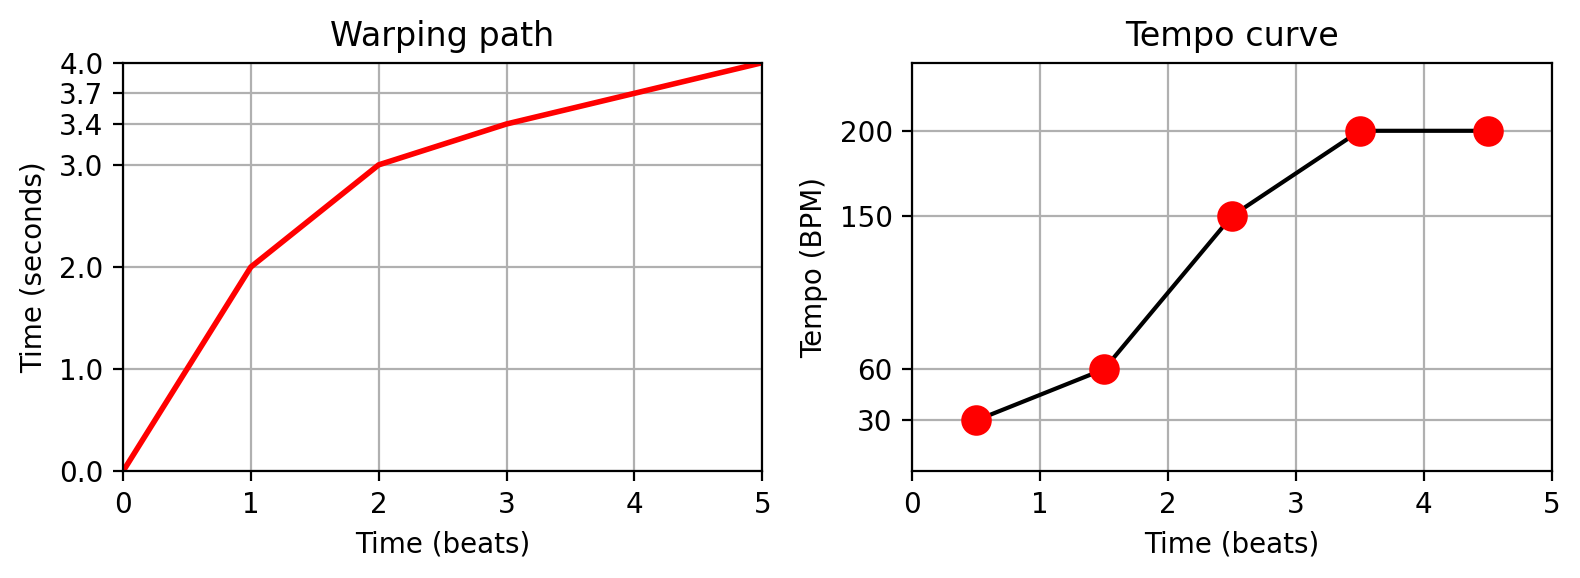

In [30]:
import os
import sys
import copy

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import librosa
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import scipy.ndimage.filters


sys.path.append('..')
import libfmp.b
import libfmp.c1
import libfmp.c3

P = np.array([[0, 0], [2, 1], [3, 2], [3.4, 3], [3.7, 4], [4, 5]])
bpm = []

pos_audio1, pos_score1 = P[0, :]
for pos_audio2, pos_score2  in P[1:]:
    dur_audio = pos_audio2 - pos_audio1
    dur_score = pos_score2 - pos_score1
    bpm.append(60 * (dur_score / dur_audio))
    pos_audio1, pos_score1 = pos_audio2, pos_score2

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].plot(P[:, 1], P[:, 0], 'r-', linewidth=2)
ax[0].set_yticks([0, 1, 2, 3.0, 3.4, 3.7, 4.0])
ax[0].grid()
ax[0].set_xlim([0, 5])
ax[0].set_ylim([0, 4])
ax[0].set_xlabel('Time (beats)')
ax[0].set_ylabel('Time (seconds)')
ax[0].set_title('Warping path')
ax[1].plot(np.arange(len(bpm)) + 0.5, bpm, 'k-')
ax[1].plot(np.arange(len(bpm)) + 0.5, bpm, 'ro', markersize=10)
ax[1].set_yticks([30, 60, 150, 200])
ax[1].grid()
ax[1].set_xlim([0, 5])
ax[1].set_ylim([0, 240])
ax[1].set_xlabel('Time (beats)')
ax[1].set_ylabel('Tempo (BPM)')
ax[1].set_title('Tempo curve')
plt.tight_layout()

In [31]:
def compute_score_chromagram(score, Fs_beat):
    """Compute chromagram from score representation

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        score (list): Score representation
        Fs_beat (scalar): Sampling rate for beat axis

    Returns:
        X_score (np.ndarray): Chromagram representation X_score
        t_beat (np.ndarray): Time axis t_beat (given in beats)
    """
    score_beat_min = min(n[0] for n in score)
    score_beat_max = max(n[0] + n[1] for n in score)
    beat_res = 1.0 / Fs_beat
    t_beat = np.arange(score_beat_min, score_beat_max, beat_res)
    X_score = np.zeros((12, len(t_beat)))

    for start, duration, pitch, velocity, label in score:
        start_idx = int(round(start / beat_res))
        end_idx = int(round((start + duration) / beat_res))
        cur_chroma = int(round(pitch)) % 12
        X_score[cur_chroma, start_idx:end_idx] += velocity

    X_score = librosa.util.normalize(X_score, norm=2)
    return X_score, t_beat
def compute_strict_alignment_path(P):
    """Compute strict alignment path from a warping path

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        P (list or np.ndarray): Warping path

    Returns:
        P_mod (list or np.ndarray): Strict alignment path
    """
    # Initialize P_mod and enforce start boundary condition
    P_mod = np.zeros(P.shape)
    P_mod[0] = P[0]
    N, M = P[-1]
    # Go through all cells of P until reaching last row or column
    assert N > 1 and M > 1, 'Length of sequences must be longer than one.'
    i, j = 0, 0
    n1, m1 = P[i]
    while True:
        i += 1
        n2, m2 = P[i]
        if n2 == N or m2 == M:
            # If last row or column is reached, quit loop
            break
        if n2 > n1 and m2 > m1:
            # Strict monotonicity condition is fulfuilled
            j += 1
            P_mod[j] = n2, m2
            n1, m1 = n2, m2
    j += 1
    # Enforce end boundary condition
    P_mod[j] = P[-1]
    P_mod = P_mod[:j+1]
    return P_mod

def compute_tempo_curve(score, x, Fs=22050, Fs_beat=10, N=4410, H=2205, shift=0,
                        sigma=np.array([[1, 0], [0, 1], [2, 1], [1, 2], [1, 1]]),
                        win_len_beat=4):
    """Compute a tempo curve

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        score (list): Score representation
        x (np.ndarray): Audio signal
        Fs (scalar): Samping rate of audio signal (Default value = 22050)
        Fs_beat (scalar): Sampling rate for beat axis (Default value = 10)
        N (int): Window size for computing audio chromagram (Default value = 4410)
        H (int): Hop size for computing audio chromagram (Default value = 2205)
        shift (int): Cyclic chroma shift applied to audio chromagram (Default value = 0)
        sigma (np.ndarray): Step size set used for DTW
            (Default value = np.array([[1, 0], [0, 1], [2, 1], [1, 2], [1, 1]]))
        win_len_beat (float): Window length (given in beats) used for smoothing tempo curve (Default value = 4)

    Returns:
        f_tempo (np.ndarray): Tempo curve
        t_beat (np.ndarray): Time axis (given in beats)
    """

    # Compute score an audio chromagram
    X_score, t_beat = compute_score_chromagram(score, Fs_beat)
    Fs_X = Fs / H
    X = librosa.feature.chroma_stft(y=x, sr=Fs, norm=2, tuning=0, hop_length=H, n_fft=N)
    X = np.roll(X, shift, axis=0)

    # Apply DTW to compte C, D, P
    C = libfmp.c3.compute_cost_matrix(X, X_score, metric='euclidean')
    D, P = librosa.sequence.dtw(C=C, step_sizes_sigma=sigma)
    P = P[::-1, :]  # reverse P
    P_mod = compute_strict_alignment_path(P)

    # Convert path into beat-time function and interpolte
    t_path_beat = P_mod[:, 1] / Fs_beat
    f_path_sec = P_mod[:, 0] / Fs_X
    f_sec = interp1d(t_path_beat, f_path_sec, kind='linear', fill_value='extrapolate')(t_beat)

    # Compute difference and smooth with Hann window
    f_diff_sec = np.diff(f_sec) * Fs_beat
    pad = np.array([f_diff_sec[-1]])
    f_diff_sec = np.concatenate((f_diff_sec, pad))
    # f_diff_sec = np.concatenate((f_diff_sec, np.array([0]) ))
    filt_len = int(win_len_beat * Fs_beat)
    filt_win = signal.windows.hann(filt_len)
    filt_win = filt_win / np.sum(filt_win)
    f_diff_smooth_sec = scipy.ndimage.filters.convolve(f_diff_sec, filt_win, mode='reflect')

    # Compute tempo curve
    f_tempo = 1. / f_diff_smooth_sec * 60

    return f_tempo, t_beat

In [32]:
def plot_measure(ax, measure_pos):
    """Plot measure positions

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        ax (mpl.axes.Axes): Figure axis
        measure_pos (list or np.ndarray): Array containing measure positions
    """
    y_min, y_max = ax.get_ylim()
    ax.vlines(measure_pos, y_min, y_max, color='r')
    for m in range(len(measure_pos)):
        ax.text(measure_pos[m], y_max, '%s' % (m + 1),
                color='r', backgroundcolor='mistyrose',
                verticalalignment='top', horizontalalignment='left')


In [33]:
def plot_tempo_curve(f_tempo, t_beat, ax=None, figsize=(8, 2), color='k', logscale=False,
                     xlabel='Time (beats)', ylabel='Temp (BPM)', xlim=None, ylim=None,
                     label='', measure_pos=[]):
    """Plot a tempo curve

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        f_tempo: Tempo curve
        t_beat: Time axis of tempo curve (given as sampled beat axis)
        ax: Plot either as figure (ax==None) or into axis (ax==True) (Default value = None)
        figsize: Size of figure (Default value = (8, 2))
        color: Color of tempo curve (Default value = 'k')
        logscale: Use linear (logscale==False) or logartihmic (logscale==True) tempo axis (Default value = False)
        xlabel: Label for x-axis (Default value = 'Time (beats)')
        ylabel: Label for y-axis (Default value = 'Temp (BPM)')
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for x-axis (Default value = None)
        label: Figure labels when plotting into axis (ax==True) (Default value = '')
        measure_pos: Plot measure positions as spefified (Default value = [])

    Returns:
        fig: figure handle
        ax: axes handle
    """
    ax.plot(t_beat, f_tempo, color=color, label=label)
    ax.set_title('Tempo curve')
    #ax.set_xlim(xlim)
    #ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, which='both')
    if logscale:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_minor_formatter(ScalarFormatter())
        # ax.set_yticks([], minor=True)
        # yticks = np.arange(ylim[0], ylim[1]+1, 10)
        # ax.set_yticks(yticks)
    plot_measure(ax, measure_pos)
    return ax

In [34]:
fn_score = 'data\C3\FMP_C3S3_Schumann_Op15No7_Traeumerei_MusicXML.csv'

df = pd.read_csv(fn_score, sep=';')
measure_pos_beat = np.array([1, 5, 9, 13, 17, 21, 25, 29, 33])
print('First six note events of score CVS file:')
print(df.loc[0:5, :])

# score = libfmp.c1.csv_to_list(fn_score)

First six note events of score CVS file:
   Start  Duration  Pitch  Velocity  Instrument
0    0.0       1.0   60.0   0.70866         NaN
1    1.0       1.0   41.0   0.70866         NaN
2    1.0       4.0   41.0   0.70866         NaN
3    1.0       2.0   65.0   0.70866         NaN
4    2.0       3.0   48.0   0.70866         NaN
5    2.0       3.0   53.0   0.70866         NaN


C:\Users\behro\AppData\Local\Temp\ipykernel_11056\2394774180.py:113: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_diff_smooth_sec = scipy.ndimage.filters.convolve(f_diff_sec, filt_win, mode='reflect')


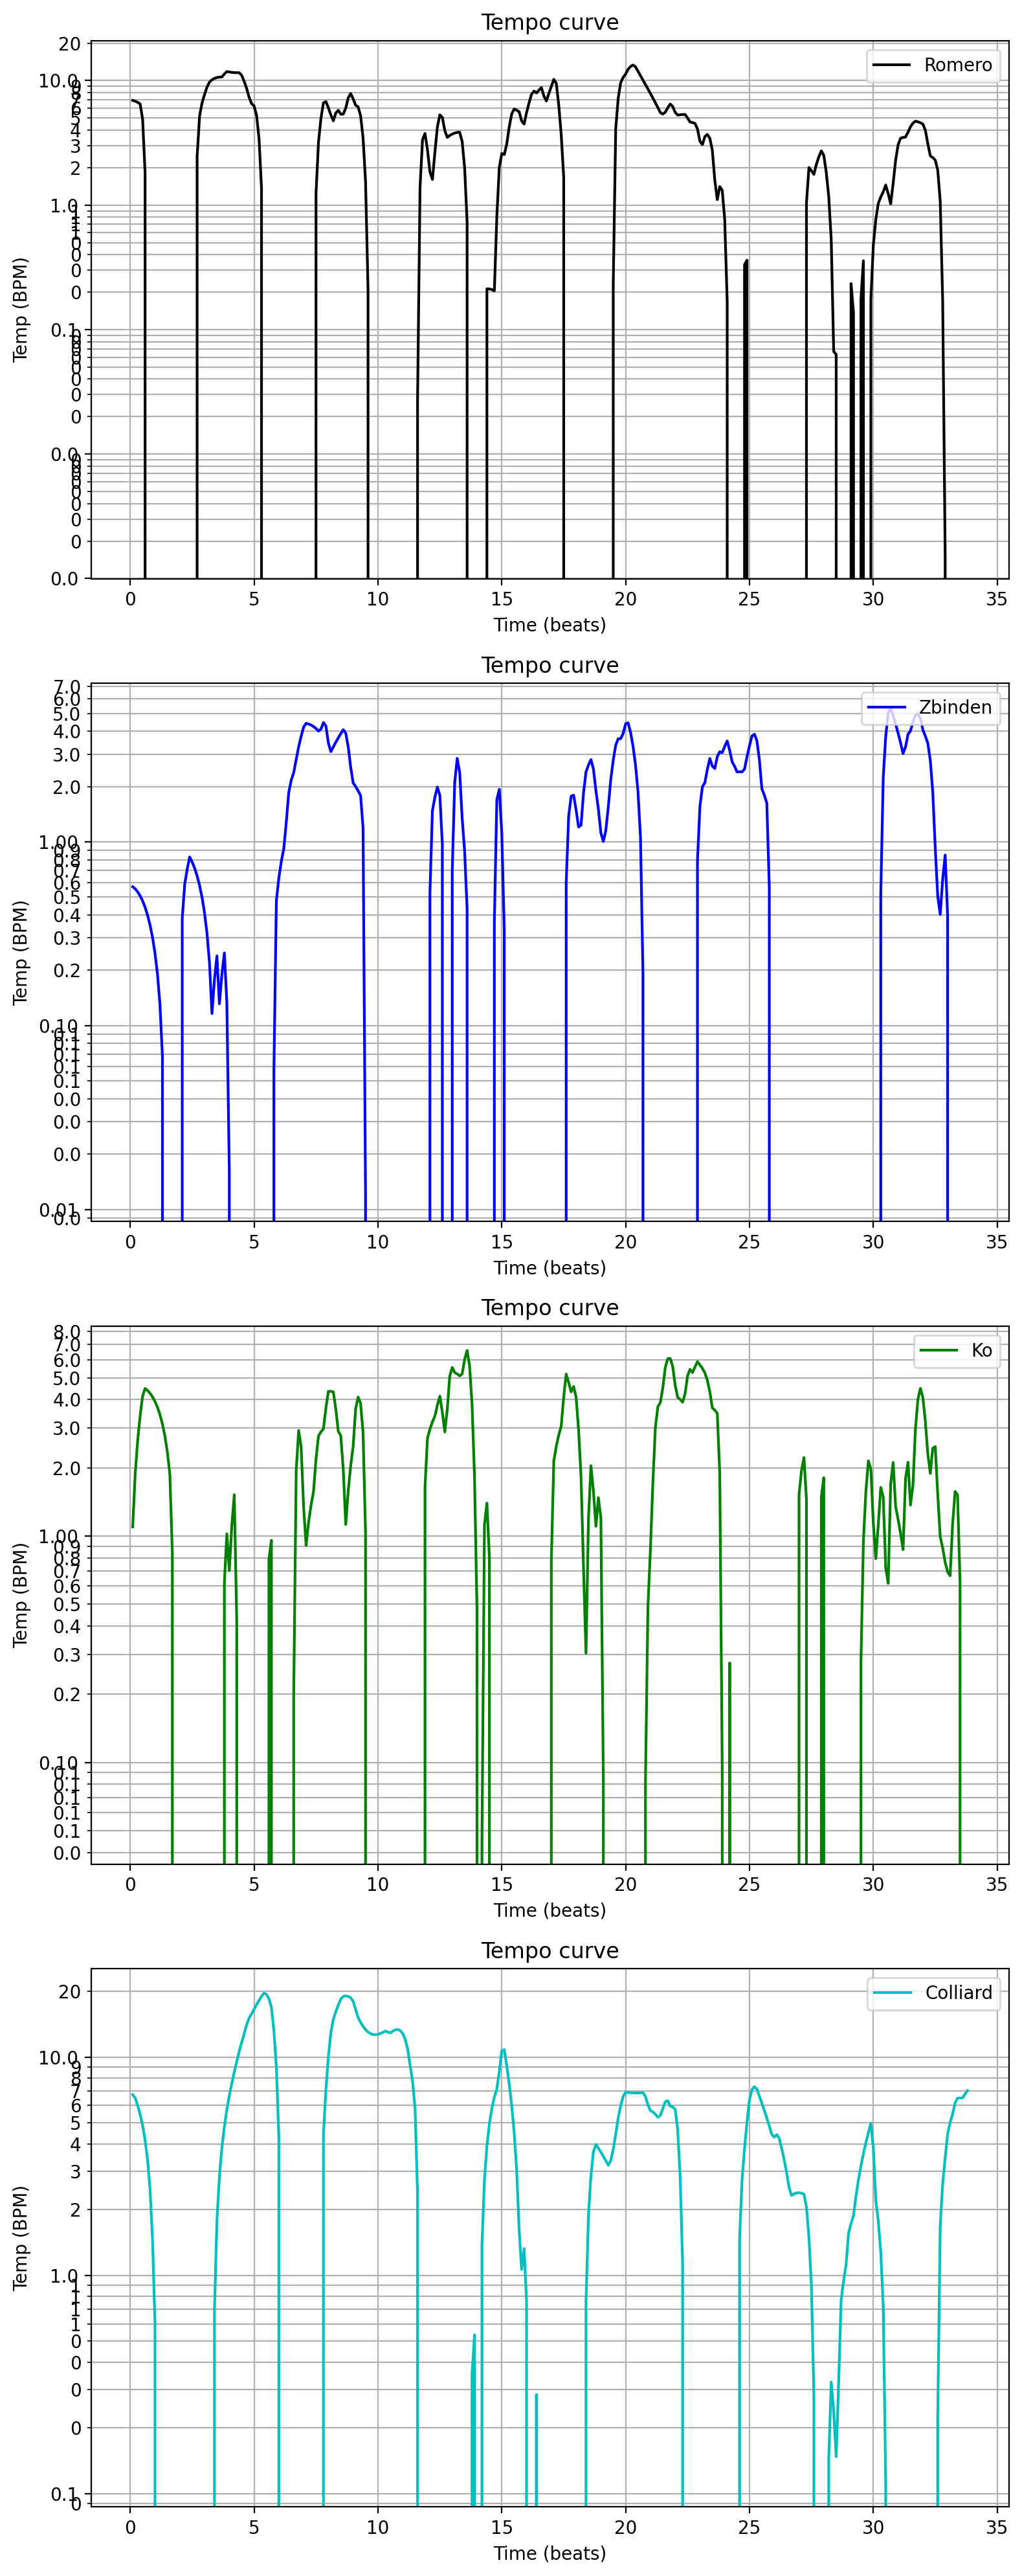

In [35]:
ylim = [28, 120]

para_dict = {}
para_dict[0] = ['Romero', 'k', 0,
                os.path.join( 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_HernandezRomero.wav')]
para_dict[1] = ['Zbinden', 'b', 0,
                os.path.join( 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_Zbinden.wav')]
para_dict[2] = ['Ko', 'g', 0,
                os.path.join( 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_TimKo.wav')]
para_dict[3] = ['Colliard', 'c', -5,
                os.path.join( 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_ColliardLigoratti.wav')]
fig, ax = plt.subplots(len(para_dict), 1,figsize=(8, 20))
for i,n in enumerate(para_dict):
    performer, color, shift, fn_wav = para_dict[n]
    Fs = 22050
    x, Fs = librosa.load(path=fn_wav,sr= Fs)
    win_len_beat = 6
    Fs_beat = 10
    f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
    f_tempo = np.diff(f_tempo)/np.diff(t_beat)
    t_beat = t_beat[:-1]+np.diff(t_beat)/2
    f_tempo = np.diff(f_tempo)/np.diff(t_beat)
    t_beat = t_beat[:-1]+np.diff(t_beat)/2
    plot_tempo_curve(f_tempo, t_beat, ax=ax[i], color=color, label=performer,
                         logscale=True)
    ax[i].legend(loc='upper right')

plt.tight_layout()

data\C3\FMP_C3S3_Schumann_Op15No7_Traeumerei_HernandezRomero.wav
data\C3\FMP_C3S3_Schumann_Op15No7_Traeumerei_Zbinden.wav
data\C3\FMP_C3S3_Schumann_Op15No7_Traeumerei_TimKo.wav


C:\Users\behro\AppData\Local\Temp\ipykernel_11056\2394774180.py:113: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_diff_smooth_sec = scipy.ndimage.filters.convolve(f_diff_sec, filt_win, mode='reflect')


data\C3\FMP_C3S3_Schumann_Op15No7_Traeumerei_ColliardLigoratti.wav


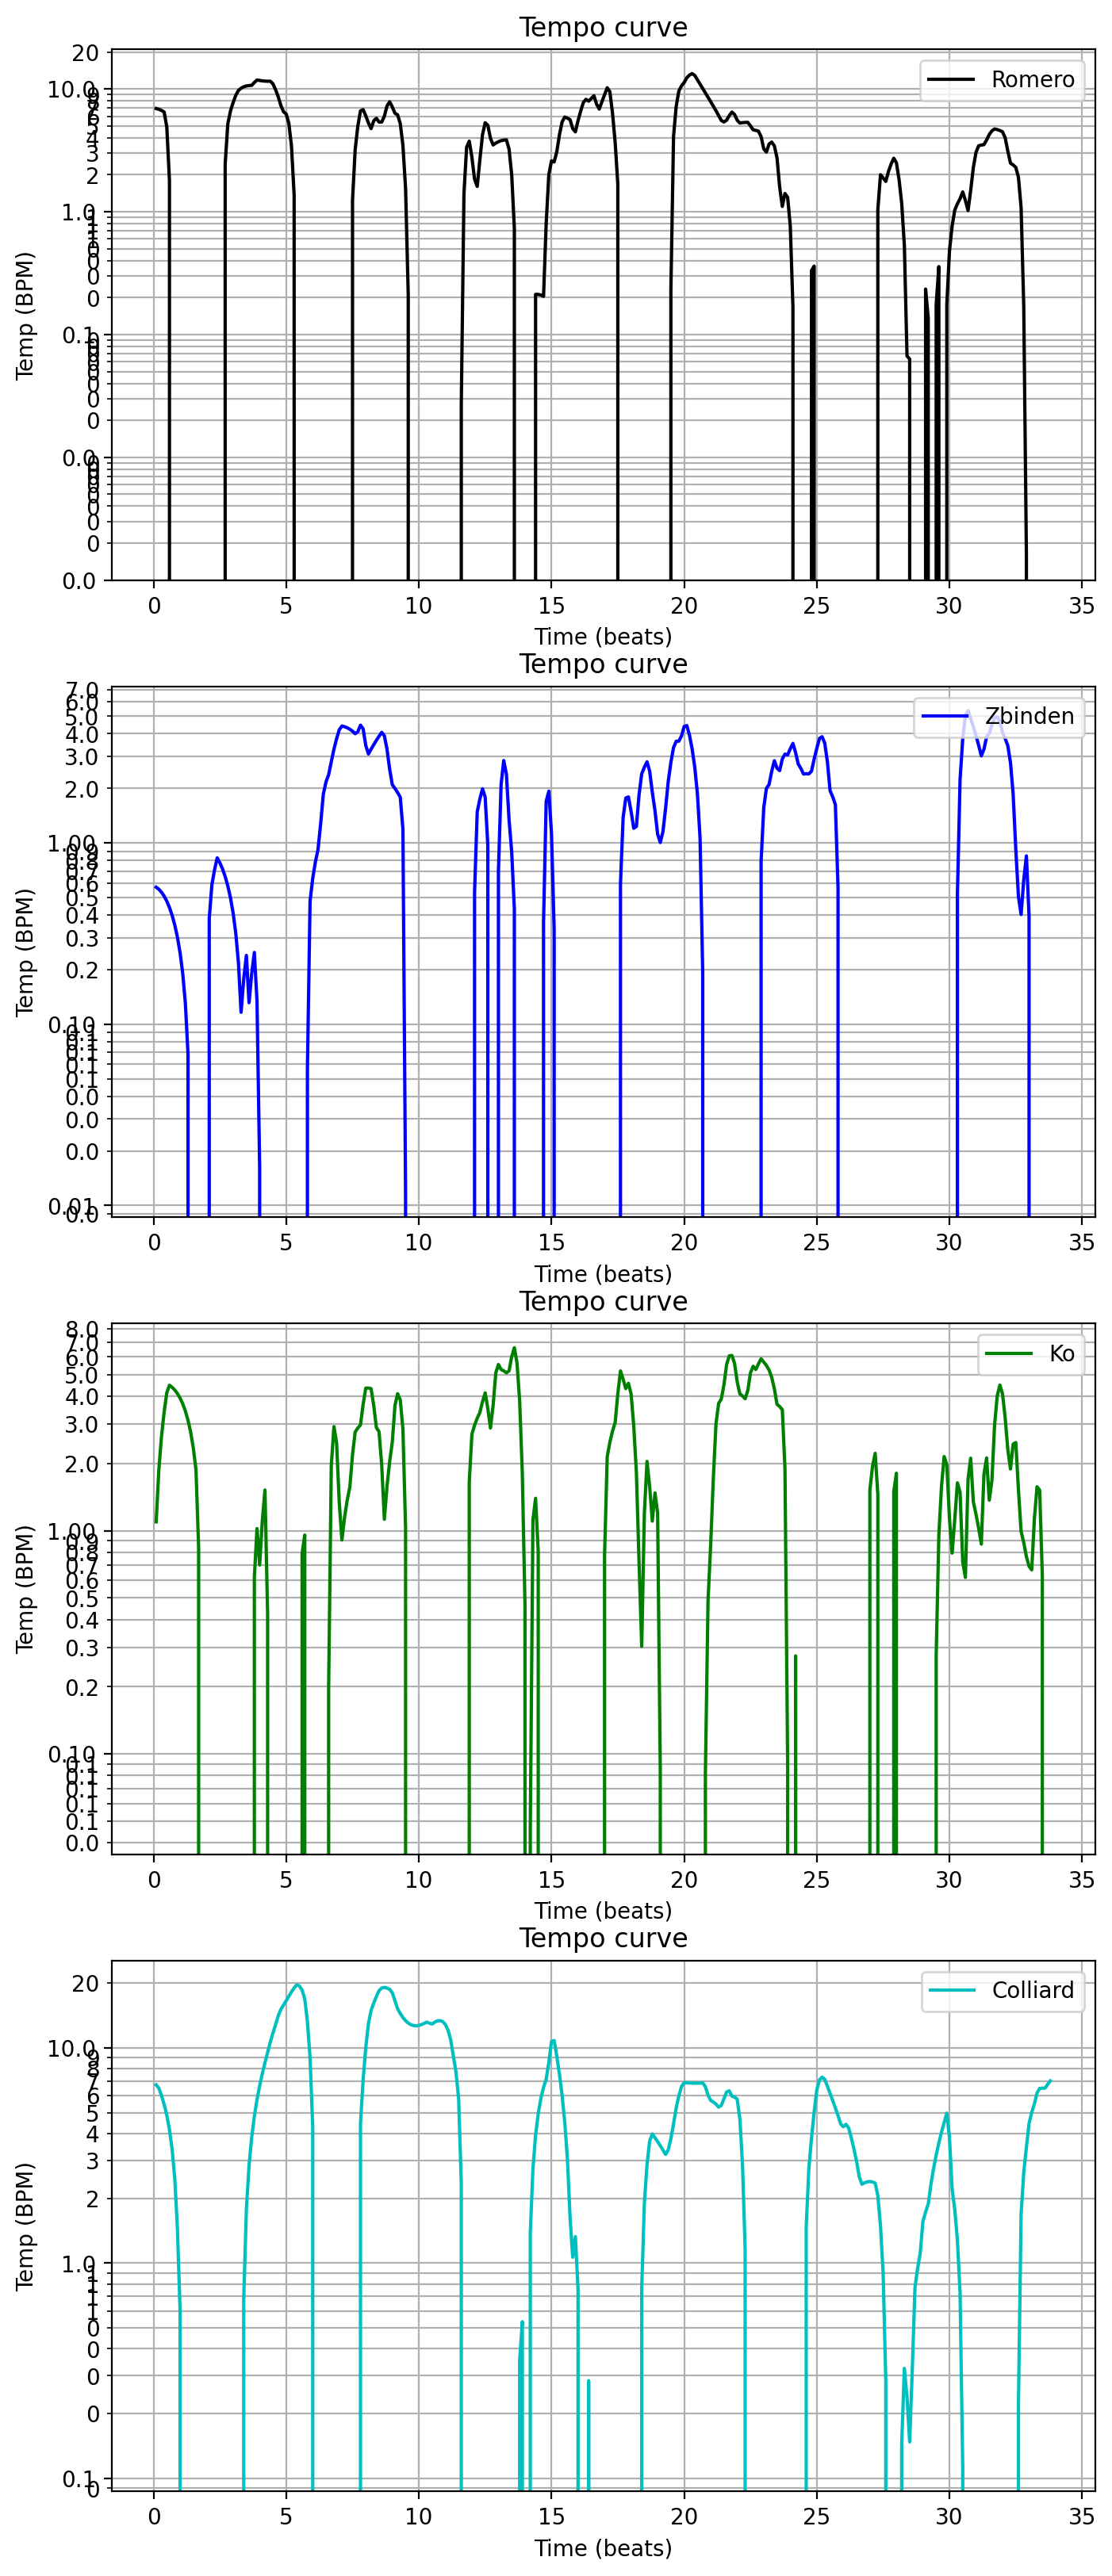

In [36]:

para_dict = {}
para_dict[0] = ['Romero', 'k', 0,
                os.path.join( 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_HernandezRomero.wav')]
para_dict[1] = ['Zbinden', 'b', 0,
                os.path.join( 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_Zbinden.wav')]
para_dict[2] = ['Ko', 'g', 0,
                os.path.join( 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_TimKo.wav')]
para_dict[3] = ['Colliard', 'c', -5,
                os.path.join( 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_ColliardLigoratti.wav')]
fig, ax = plt.subplots(len(para_dict), 1,figsize=(8, 20))
for i,n in enumerate(para_dict):
    performer, color, shift, fn_wav = para_dict[n]
    Fs = 22050
    print(fn_wav)
    x, Fs = librosa.load(path=fn_wav,sr= Fs)
    win_len_beat = 6
    Fs_beat = 10
    f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
    f_tempo = np.diff(f_tempo)/np.diff(t_beat)
    t_beat = t_beat[:-1]+np.diff(t_beat)/2
    f_tempo = np.diff(f_tempo)/np.diff(t_beat)
    t_beat = t_beat[:-1]+np.diff(t_beat)/2
    plot_tempo_curve(f_tempo, t_beat, ax=ax[i], color=color, label=performer,
                         logscale=True)
    ax[i].legend(loc='upper right')

plt.show()

1_Audio\Beethoven_Op002No1-01_AS35.wav


C:\Users\behro\AppData\Local\Temp\ipykernel_11056\2394774180.py:113: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_diff_smooth_sec = scipy.ndimage.filters.convolve(f_diff_sec, filt_win, mode='reflect')


1_Audio\Beethoven_Op002No1-01_FG58.wav
1_Audio\Beethoven_Op002No1-01_FJ62.wav
1_Audio\Beethoven_Op002No1-01_WK64.wav


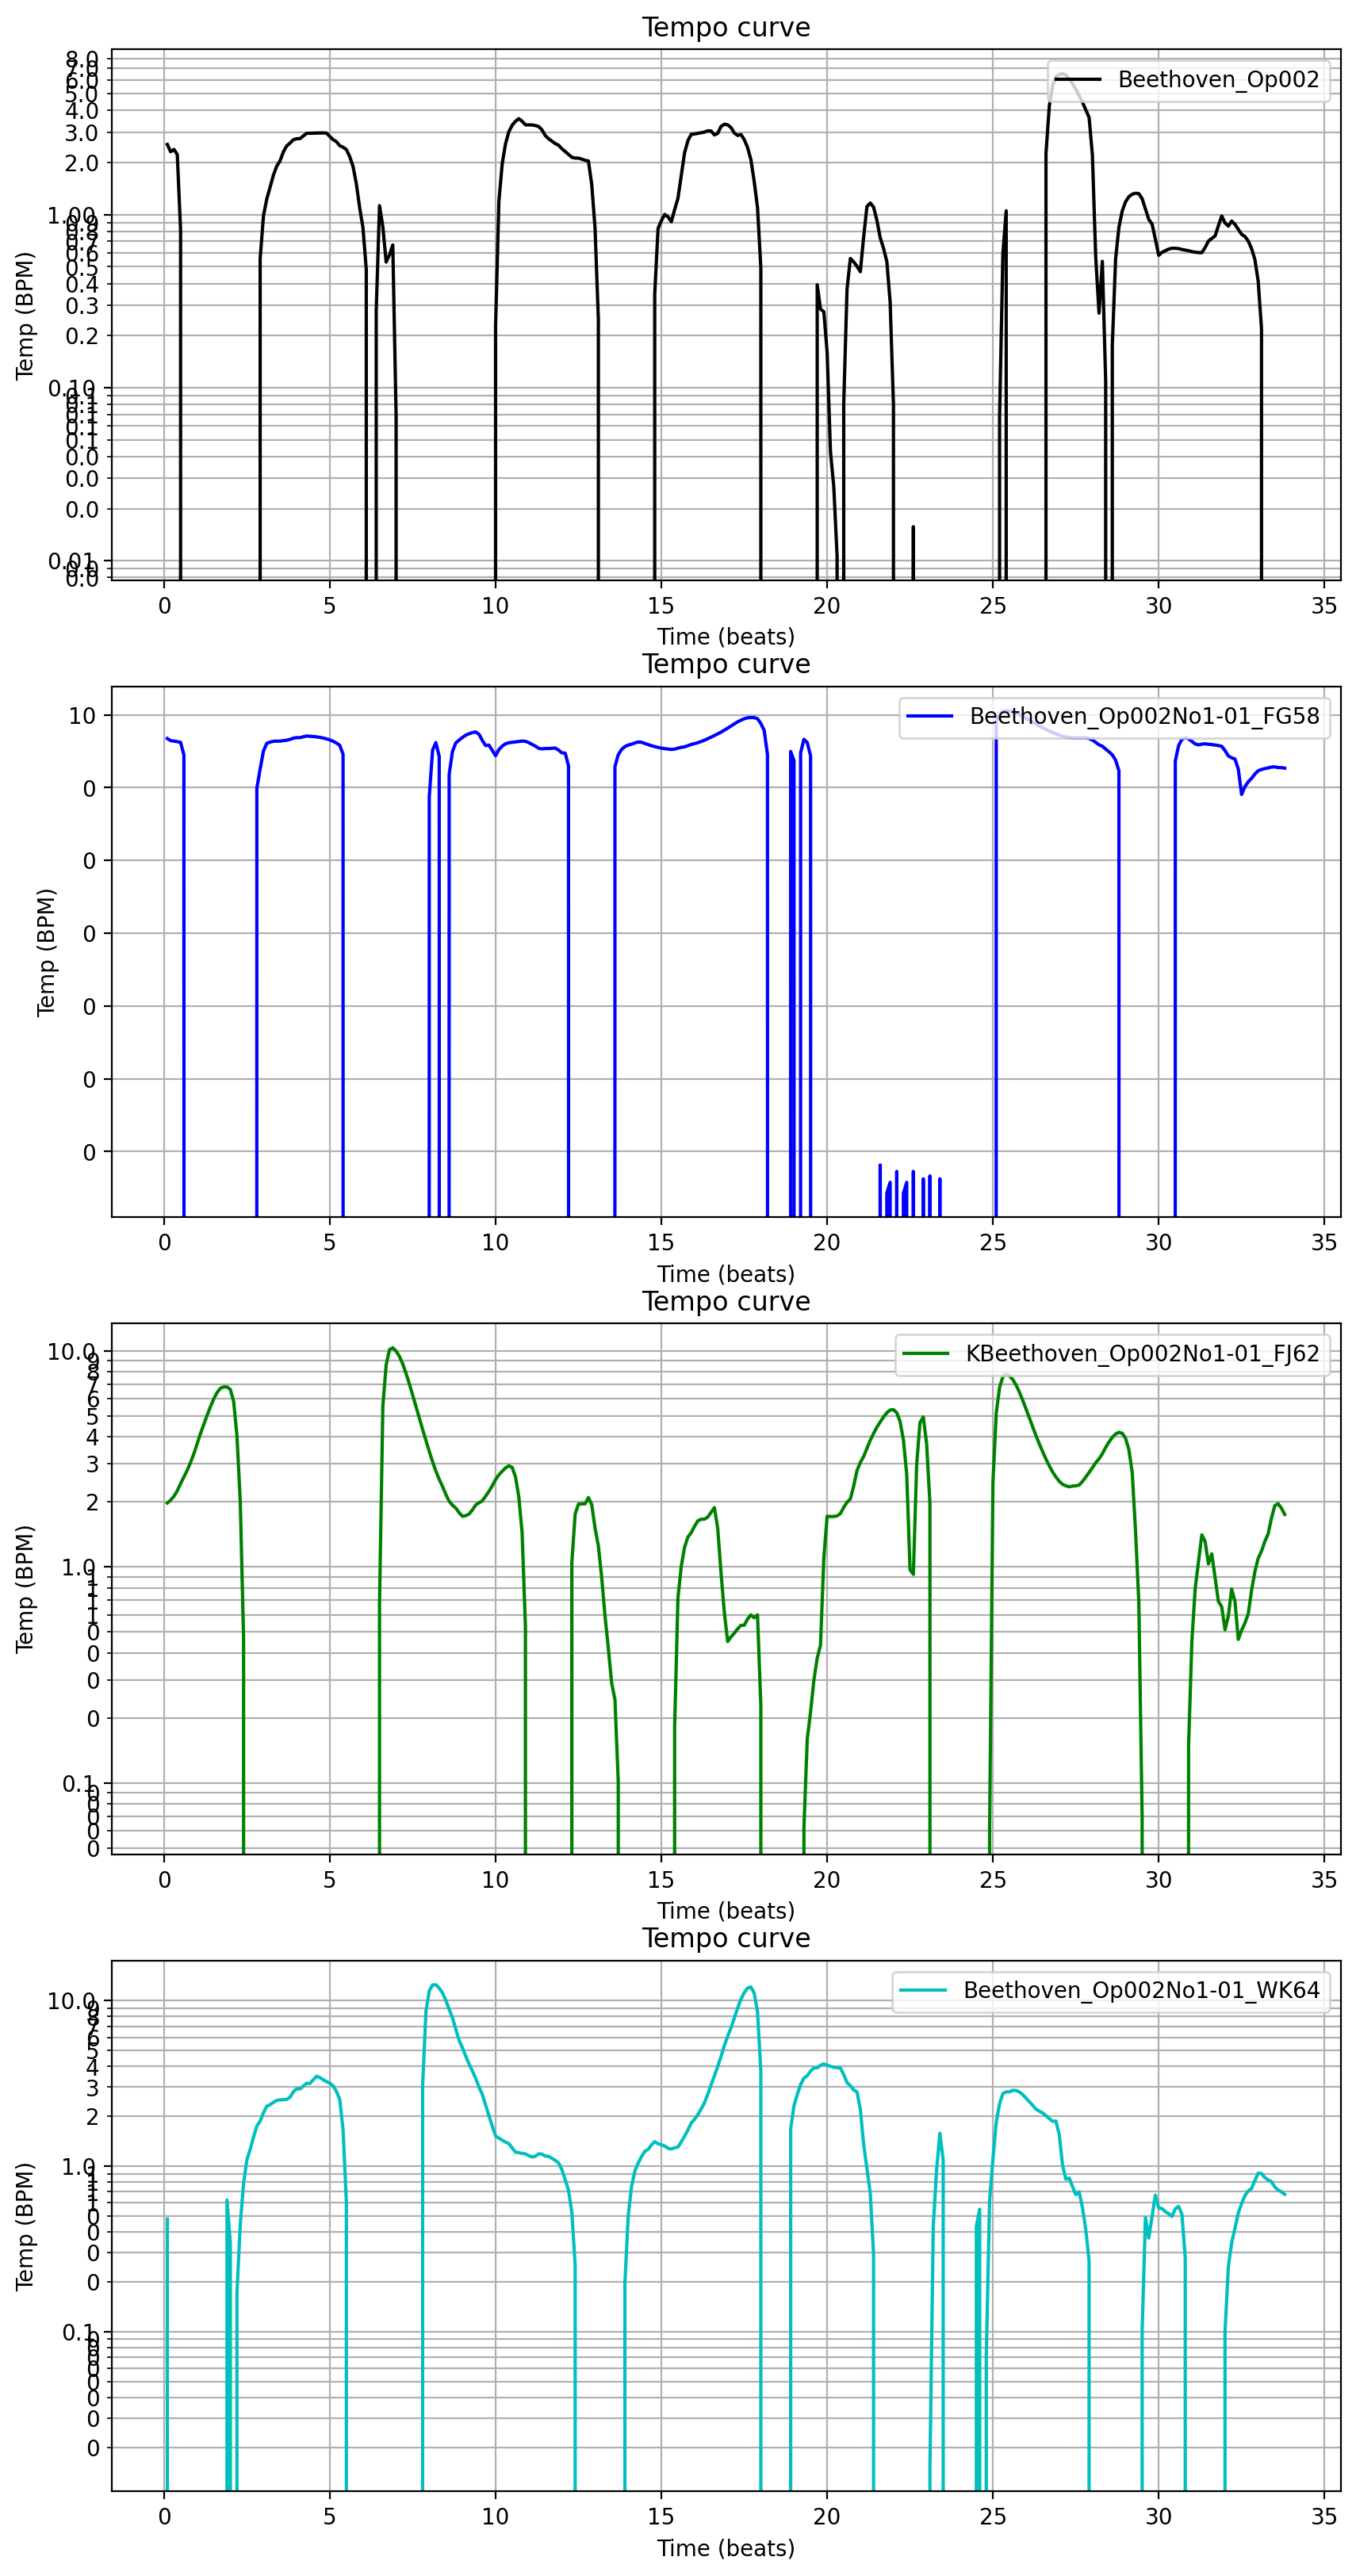

In [37]:
para_dict = {}
para_dict[0] = ['Beethoven_Op002', 'k', 0,
                os.path.join( '1_Audio', 'Beethoven_Op002No1-01_AS35.wav')]
para_dict[1] = ['Beethoven_Op002No1-01_FG58', 'b', 0,
                os.path.join( '1_Audio', 'Beethoven_Op002No1-01_FG58.wav')]
para_dict[2] = ['KBeethoven_Op002No1-01_FJ62', 'g', 0,
                os.path.join( '1_Audio', 'Beethoven_Op002No1-01_FJ62.wav')]
para_dict[3] = ['Beethoven_Op002No1-01_WK64', 'c', -5,
                os.path.join( '1_Audio','Beethoven_Op002No1-01_WK64.wav')]
fig, ax = plt.subplots(len(para_dict), 1,figsize=(10, 20))
for i,n in enumerate(para_dict):
    performer, color, shift, fn_wav = para_dict[n]
    Fs = 22050
    print(fn_wav)
    x, Fs = librosa.load(path=fn_wav,sr= Fs)
    win_len_beat = 6
    Fs_beat = 10
    f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
    f_tempo = np.diff(f_tempo)/np.diff(t_beat)
    t_beat = t_beat[:-1]+np.diff(t_beat)/2
    f_tempo = np.diff(f_tempo)/np.diff(t_beat)
    t_beat = t_beat[:-1]+np.diff(t_beat)/2
    plot_tempo_curve(f_tempo, t_beat, ax=ax[i], color=color, label=performer,
                         logscale=True)
    ax[i].legend(loc='upper right')
